In [12]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

In [13]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306534 rows


# Project Ideas
## Find out active/inactive customers before the 1st offer came in
- Compare customer events before they got first offer VS after they got first offer
- Do not send offers to those who were already active
- Do not send offers to those who complete offers but don't view offers (they might not like them)

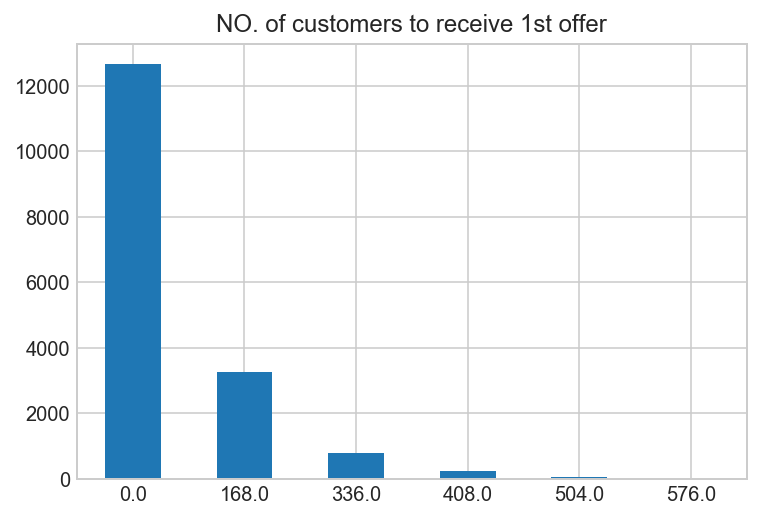

In [14]:
waves = events.query("event == 'offer received'").groupby('customer_id').hour.min().to_frame().rename({'hour':'first_offer_hour'},axis=1).reset_index()
# print(f'customers received the first offer at 6 different "waves": {sorted(waves.first_offer_hour.unique())}')
waves.first_offer_hour.value_counts().plot(kind='bar');
plt.xticks(rotation=360); plt.title('NO. of customers to receive 1st offer');

In [15]:
def get_wave_ids(hour):
    '''
    input:
        hours - hours after start of the test to receive the first offer (0,168,336,408,504,576)
    output:
        ids - list of customer ids who got their first offers on this time
    
    '''
    ids = list(waves[waves.first_offer_hour == hour].customer_id)
    return ids

# wave1_ids = get_wave_ids(0)
# wave2_ids = get_wave_ids(168)
# wave3_ids = get_wave_ids(336)
# wave4_ids = get_wave_ids(408)
# wave5_ids = get_wave_ids(504)
# wave6_ids = get_wave_ids(576)

# assert np.sum([len(wave1_ids), len(wave2_ids), len(wave3_ids), len(wave4_ids), len(wave5_ids), len(wave6_ids)]) + 6 == events.customer_id.nunique()

In [16]:
# # Merge offers to events
# events_offers = pd.merge(events, offers, how='left', left_on='offer_id', right_on='id').drop('id',axis=1)
# events_offers.head()

In [17]:
time_of_waves = [0,168,336,408,504,576]

In [20]:
def create_pre_post_offer_events():

    '''
    input:
        None
    output:
        pre_offer_events - customer events before receiving the first offer
        post_offer_events - customer events after receiving the first offer
    '''

    pre_offer_events = pd.DataFrame()
    current = pd.DataFrame()

    for hour in time_of_waves:
        current = events[events.customer_id.isin(get_wave_ids(hour))]
        current = current[current.hour < hour]
        pre_offer_events = pd.concat([pre_offer_events, current])

    
    post_offer_events = pd.DataFrame()
    current = pd.DataFrame()

    for hour in time_of_waves:
        current = events[events.customer_id.isin(get_wave_ids(hour))]
        current = current[current.hour >= hour]
        post_offer_events = pd.concat([post_offer_events, current])


    # check the quality of data wrangling
    assert list(pre_offer_events.event.unique()) == ['transaction']
    assert list(post_offer_events.event.unique()) == ['offer received', 'offer viewed', 'transaction', 'offer completed']
    #assert len(pre_offer_events) + len(post_offer_events) == len(events), [len(pre_offer_events) + len(post_offer_events), len(events)]

    return pre_offer_events, post_offer_events

In [21]:
pre_offer_events, post_offer_events = create_pre_post_offer_events()

In [22]:
pre_offer_events.customer_id.nunique()

2595

In [23]:
post_offer_events.customer_id.nunique()

16994

In [25]:
events.customer_id.nunique()

16994

In [12]:
# def get_customer_events(customer_id):

#     df = events_offers[events_offers.customer_id == customer_id][['customer_id','event','hours_from_test','amount_spent','reward_received','offer_type']]
#     return df

# get_customer_events(wave5_ids[0])

### Compare the same 2595 customers events pre and post first offer
Metrics:
- transactions per week
- amount spent per week

In [37]:
print(f'{pre_offer_events.customer_id.nunique()} customers in pre_offer_events')
print(f'type of events: {pre_offer_events.event.unique()}')
pre_offer_events.head()

2595 customers in pre_offer_events
type of events: ['transaction']


,customer_id,event,hours_from_test,offer_id,amount_spent,reward_received
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23,NaN
12849,098d124614df4e4b862d678160b98638,transaction,0,NaN,1.21,NaN
12853,98b81a8ffdd14bb986d80673491171a7,transaction,0,NaN,7.40,NaN
12914,ad18ad432f5a40c7b8ccce4be4fb530c,transaction,0,NaN,17.00,NaN
12994,2372a5dd677842478b5318e4ea525969,transaction,0,NaN,12.88,NaN


In [47]:
pre_offer_events['day'] = (pre_offer_events.hours_from_test/24 + 1).astype(int)
pre_offer_events['week'] = (pre_offer_events.hours_from_test/24/7 + 1).astype(int)
pre_offer_events.sample(5)

,customer_id,event,hours_from_test,offer_id,amount_spent,reward_received,day,week
99776,12f7dc81c39a4db59177faaa1769a0dc,transaction,270,NaN,2.95,NaN,12,2
42397,da20295eb3b941699487566a84dbac6f,transaction,102,NaN,4.97,NaN,5,1
107848,b50d7e5567f14070bd95e2c2a45e60f4,transaction,312,NaN,3.17,NaN,14,2
95468,dc9685d8f9da415a805aca82c02f4b92,transaction,252,NaN,4.89,NaN,11,2
37924,6a6fd7b30c434e2f9dc09b0a38b7a08a,transaction,78,NaN,2.85,NaN,4,1


In [50]:
same_group_post_events = post_offer_events[post_offer_events.customer_id.isin(pre_offer_events.customer_id)]
same_group_post_events['day'] = (same_group_post_events.hours_from_test/24 + 1).astype(int)
same_group_post_events['week'] = (same_group_post_events.hours_from_test/24/7 + 1).astype(int)
same_group_post_events.sample(5)

,customer_id,event,hours_from_test,offer_id,amount_spent,reward_received,day,week
236433,9ca1196e54194ca9bf1a4b1327715e9e,offer viewed,546,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,23,4
200239,84df7379c5ef440c95487180a6901ee6,transaction,498,NaN,23.70,NaN,21,3
192759,c2b271aa4c804b208107830bb5d22a66,transaction,468,NaN,10.29,NaN,20,3
220260,f6f2f1b135c64f0caad1acdb7ff5bffa,offer viewed,510,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,22,4
242459,3ae3b5f2473b40cc807427b31cc8ad4b,transaction,564,NaN,20.56,NaN,24,4


In [51]:
assert pre_offer_events.customer_id.nunique() == same_group_post_events.customer_id.nunique()

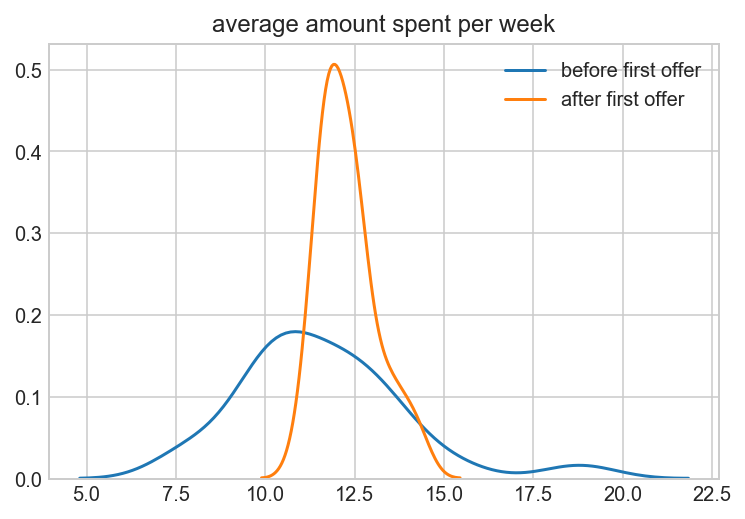

In [63]:
sns.kdeplot(pre_offer_events.groupby('day').amount_spent.mean(), label='before first offer');
sns.kdeplot(same_group_post_events.groupby('day').amount_spent.mean(), label='after first offer');
plt.title('average amount spent per week');

In [52]:
pre_offer_events.groupby('week').amount_spent.mean()

week
1    12.895596
2    10.753291
3    10.382532
4    11.976364
Name: amount_spent, dtype: float64

In [53]:
same_group_post_events.groupby('week').amount_spent.mean()

week
2    12.095157
3    12.422165
4    12.377293
5    12.147597
Name: amount_spent, dtype: float64

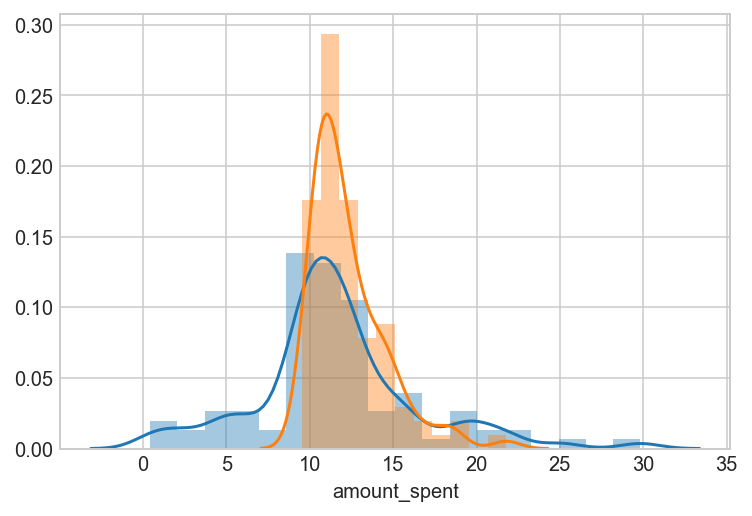

In [35]:
sns.distplot(pre_offer_events.groupby('hours_from_test').amount_spent.mean());
sns.distplot(same_group_post_events.groupby('hours_from_test').amount_spent.mean());

In [19]:
# print(f'{post_offer_events.customer_id.nunique()} customers in post_offer_events')
# print(f'type of events: {post_offer_events.event.unique()}')
# post_offer_events